In this paper I will be implementing this paper https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2244633. The paper advocates for using an absolute momentum strategy. 

In [270]:
from backtester import *


The original paper used MSCI monthly data, I will use daily close data for all of the time periods available.

In [271]:
close_data = getdata('MSCI', '10y', 'Close', "1mo")


The momentum strategy uses a 12 formation period, 12 months is used because it was found in the paper to have the greatest Sharpe ratio.

In [272]:
data = pd.DataFrame(close_data).copy().dropna()
display(data)


,Close
Date,
2012-11-01,26.553520
2012-12-01,28.375633
2013-01-01,30.893646
2013-02-01,30.335106
2013-03-01,31.067614
...,...
2022-07-01,480.165131
2022-08-01,448.143494
2022-09-01,421.790009


Rather than selling and holding cash, in the paper the strategy will have us buy treasury bonds, in this case I have used is the 13 week treasury bond, as the paper did. The figures given by yfinance is the 3 month treasury 

In [273]:
tresurybond = getdata('^IRX', '10y', 'Close', "1mo")

In [274]:
treasurydata = pd.DataFrame(tresurybond).copy().dropna().rename(columns={'Close':'TByeild'})
display(treasurydata)


,TByeild
Date,
2012-11-01,0.075
2012-12-01,0.035
2013-01-01,0.065
2013-02-01,0.100
2013-03-01,0.065
...,...
2022-07-01,2.298
2022-08-01,2.860
2022-09-01,3.180


The original paper has positions revaluated monthly, however given that I only have a maximum of 10 years worth of data I will do this weekly.

In [275]:
# Creating the buy and sell signals based on the momentum of the previous 12 months. 

def momentum(data_levels,tbonds, period = 12, tollerence = 0.00):
    
    #Combine the two dataframes so we arent going between multiple dataframes
    
    data = pd.merge(data_levels,tbonds,left_index=True, right_index=True, how='outer')
    
    # The first thing that we need to do is work out the formation periods for the strategy, the default is 12 months.
    # It takes the percentage increase in the price of the asset and takes away the yield on the 13 week bill. If this number is positive then the asset is outperforming the bill, if it is negative then the asset is not.
    
    data['Signals']  = (((data['Close']-data['Close'].shift(periods= 12))/data['Close'].shift(periods= 12))-data['TByeild']).dropna()

    data['Signals'] = data['Signals'].apply(lambda x: +1 if x>=0 else -1)
    
    # Traditionally we would also look at the month ahead and decide if we should buy or sell, however given that we are backtesting, we would be implementing look ahead bias. 
    # If the price we due to decrease we would sell thus ensuring that positive returns are always made. Therefore I will only use the previous 12 months as indicative of momentum. 
    #This is analogous to the papers methodology. 
    return data

The usual backtester that I have used will not be applicable here, given that the paper suggests that instead of holding cash when not holding MSCI, it would suggest buying 13 week treasury bonds. 

In [276]:
#now that we have the data make a back tester to check if it will work take the two columns the price 

def backtestert(signals,price,tbill , tcost = 0.001):

#Make a quick numpy array to save the money that will be made for possible value that the stock could be sold at and the cash on hand, start with one dollar so its not empty.

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1
        
        #loop through each day as though we are going through and actually implementing the strategy as we go

        for i,val in enumerate(price):
            
            #if we are on the last day exit the loop we are done.

            if i == len(price)-1:
                break
            
            # The number we are given for the 3 month bill is the annualized yield, however we might only want to hold this bill for a month, so we need to work out the monthly returns on the bill.

            if signals[i] == -1:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]*(1+(tbill[i]/12)/100)
                pos_val[i+1] = 0
                
            #If the signal that day is to buy, what we will do is take all of the cash that we have, divide it by the cost of the coin to work out how many we can buy
            #factoring in the cost of the brockerage, we then add it to any stock we held from the pervious day

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0

        #then our returns are the amount of cash left each day plus the the price times the amount of coin that we have

        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        #lastly we turn this into a data frame too
        
        return pd.DataFrame(returns, index = price.index)

Now to run the tests to see if how they perform

Winrate of ABSMomentum 0.6071428571428571
Final return of ABSMomentum 3.5999999046325684
Sharpe ratio of ABSMomentum -2.269742958410171


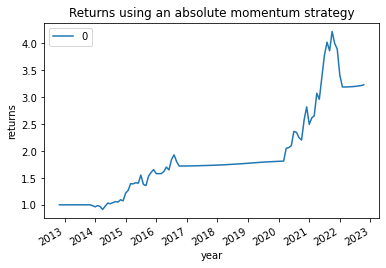

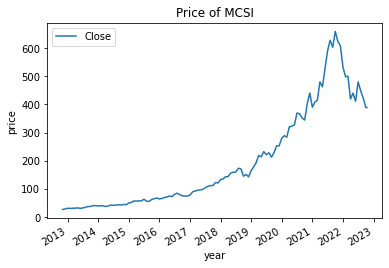

In [277]:
signals = momentum(data, treasurydata,12 , 0 )

returns = backtestert(signals['Signals'],signals['Close'],signals['TByeild'],0)
returns.plot(xlabel = 'year',ylabel='returns',title= "Returns using an absolute momentum strategy")
data.plot(xlabel='year',ylabel='price',title='Price of MCSI')

print('Winrate of ABSMomentum '+ str(winrate(signals,returns)))
print('Final return of ABSMomentum '+ str(signals.iloc[-1][1]))
print('Sharpe ratio of ABSMomentum '+ str(Sharperatio(returns,tradingdays=12,rrr=0.1 )[0]))


Having backtested the strategy proposed by the authors I have found an absolutely abysmal sharpe ratio, and a win rather that is mildly better than that of flipping a coin. Therefore as it stands this strategy does not line up with the results of the original paper, which only included data up till 2014. Therefore the strategy has not continued to work. 